# CENTRALITY IS ALL YOU NEED
## LFN Project

Cristiano Colpo (2017898): cristiano.colpo@studenti.unipd.it


Matteo Piva (2020352): matteo.piva.6@studenti.unipd.it

### Description of the project

**Aim**: 
- try to detect the most influential political figures by using algorithms related to centrality.
- assess the significance of the computed features with z-score and p-values with the Monte Carlo method

## Index

- [centralities](#centrality)
- [random graphs](#random)
- [significance check](#significance)
    - [p-values](#pvalues)
    - [z-scores](#zscores)

## Load libraries

In [79]:
#!pip install networkit
#!pip install pyvis
import networkx as nx
import networkit as nk
import csv
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
from pyvis.network import Network
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from functools import reduce

import matplotlib 


## Loading of the graph and calculation of some metrics

In [80]:
edges = pd.read_csv("data/fb-pages-politician.edges", sep = ",", header=None)
nodes = pd.read_csv("data/fb-pages-politician.nodes", sep = ",")

In [81]:
nodes

,id,name,new_id
0,127397457601670,陳根德,1661
1,169014523134260,林淑芬,52
2,295363753921281,Chris White,3477
3,613631835423903,Stewart Hosie MP,3193
4,284882801581896,Frank Schäffler,4425
...,...,...,...
5903,342943772496246,Kevin Byrne,3778
5904,193944157325672,Timur Husein,439
5905,142026376065,Jeremy Lefroy,159
5906,294019144024664,Ileana Argentin,107


In [82]:
#needs a dictionary in order to relabel the nodes
labelsDict = pd.Series(nodes.name.values,index=nodes.new_id).to_dict()

In [83]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edges,0, 1)
G = nx.relabel_nodes(G, labelsDict)

In [84]:
G.is_directed()

False

In [85]:
nkG = nk.nxadapter.nx2nk(G)

In [86]:
print("Is G connected? ",nx.is_connected(G))
print("Number of connected components: ", nx.number_connected_components(G))

Is G connected?  True
Number of connected components:  1


In [87]:
#connected components with networkit
cc = nk.components.ConnectedComponents(nkG)
cc.run()
print("number of components ", cc.numberOfComponents())
print("map of component size: ", cc.getComponentSizes())

number of components  1
map of component size:  {0: 5906}


In [88]:
#diameter (estimate)
#This algorithm gives an estimation of the diameter of a given graph. The algorithm is based on the ExactSumSweep algorithm presented in Michele Borassi, Pierluigi Crescenzi, Michel Habib, Walter A. Kosters, Andrea Marino, Frank W. Takes: http://www.sciencedirect.com/science/article/pii/S0304397515001644.
diam = nk.distance.Diameter(nkG,algo=1)
diam.run()
diam.getDiameter() 
#The return value of getDiameter is a pair of integers: the lower bound and upper bound of the diameter. 
#In the case, that we computed the exact diameter, the diameter is the first value of the pair.

(14, 0)

In [89]:
#diameter (effective)
#The effective diameter is defined as the number of edges on average to reach a given ratio of all other nodes.
#The EffectiveDiameter(G, ratio=0.9) constructor expects an undirected graph and the ratio of nodes that should be connected. The ratio must be between in the interval (0,1].
ed = nk.distance.EffectiveDiameter(nkG)
ed.run()
ed.getEffectiveDiameter()

5.816796478157806

In [90]:
#effective diameter approximation
eda = nk.distance.EffectiveDiameterApproximation(nkG)
eda.run()
eda.getEffectiveDiameter()

6.768879105993904

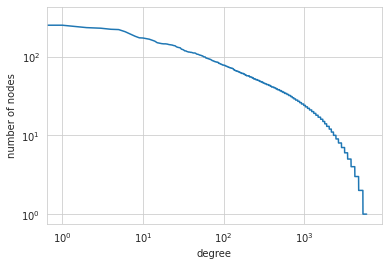

In [91]:
#degree distribution in our original graph
dd = sorted(nk.centrality.DegreeCentrality(nkG).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(dd)
plt.show()

In [92]:
top10dc = dict(nk.centrality.DegreeCentrality(nkG).run().ranking()[:10])
keys10dc = list(top10dc.keys())
values10dc = list(top10dc.values())
nodesTop10dc = nodes.set_index("new_id").loc[keys10dc]
nodesTop10dc["dc"] = values10dc
nodesTop10dc

,id,name,dc
new_id,,,
177,148900938515423,Sofie Carsten Nielsen,323.0
308,342928465888942,Alain Leboeuf,250.0
703,168468263243635,Sylviane Bulteau,233.0
746,240525239423067,Oliver Wittke,229.0
749,220778897969256,Zeca Dirceu,222.0
1392,519002898276056,Senator Andrew Mathews,220.0
157,728842613851000,Margaret Quirk MLA,207.0
209,329876810499233,Kate Green,193.0
855,232363686957754,Alexander Kulitz,181.0


In [93]:
#some info in our original graph if we are interested
communities = nk.community.detectCommunities(nkG)
nk.community.Modularity().getQuality(communities, nkG)

PLM(balanced,pc,turbo) detected communities in 0.04374408721923828 [s]
solution properties:
-------------------  ----------
# communities         29
min community size    10
max community size   596
avg. community size  203.655
modularity             0.867695
-------------------  ----------


0.8676949135919121

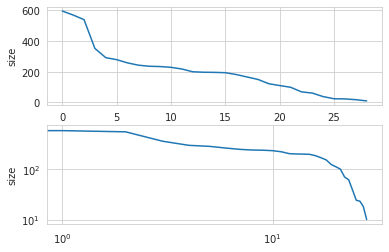

In [94]:
sizes = communities.subsetSizes()
sizes.sort(reverse=True)
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("size")
ax1.plot(sizes)

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("size")
ax2.plot(sizes)
plt.show()

## Closeness and Betweenness centrality <a id="centrality"></a>

In [95]:
def centrality(G,alg, lib):
    if alg == "closeness" and lib == "nx":
        start_time = time.time()
        colsenessCentrality_nx = nx.closeness_centrality(G)
        print("--- %s seconds ---" % (time.time() - start_time))
        return colsenessCentrality_nx
    if alg == "betweenness" and lib == "nx":
        start_time = time.time()
        betweennessCentrality_nx = nx.betweenness_centrality(G)
        print("--- %s seconds ---" % (time.time() - start_time))
        return betweennessCentrality_nx
    if alg == "closeness" and lib == "nk":
        start_time = time.time()
        # default normalized=False
        nkColsenessCentrality = nk.centrality.Closeness(G,True,False).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkColsenessCentrality.ranking()
    if alg == "betweenness" and lib == "nk":
        start_time = time.time()
        # default normalized=False
        nkBetweennessCentrality = nk.centrality.Betweenness(G,True,False).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkBetweennessCentrality.ranking()
    if alg == "approxclose" and lib == "nk":
        start_time = time.time()
        # default normalized=False
        nkApproxColsenessCentrality = nk.centrality.ApproxCloseness(G,100, epsilon=0.05, normalized=True).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkApproxColsenessCentrality.ranking()
    if alg == "approxbet" and lib == "nk":
        start_time = time.time()
        nkApproxBetweennessCentrality = nk.centrality.ApproxBetweenness(G,epsilon=0.05).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkApproxBetweennessCentrality.ranking()

In [96]:
cc = centrality(nkG,"closeness","nk")

--- 0.4918100833892822 seconds ---


In [97]:
top10cc = dict(cc[:10])
keys10cc = list(top10cc.keys())
values10cc = list(top10cc.values())
nodesTop10cc = nodes.set_index("new_id").loc[keys10cc]
nodesTop10cc["cc"] = values10cc
nodesTop10cc

,id,name,cc
new_id,,,
703,168468263243635,Sylviane Bulteau,0.358857
853,336733203010225,Assemblyman Ray Walter,0.323508
941,384662044972285,"Norbert Spinrath, MdB",0.320471
855,232363686957754,Alexander Kulitz,0.317422
228,449533531817208,Alejandra Morlan,0.312467
157,728842613851000,Margaret Quirk MLA,0.310855
50,169196224815,Giovanni Capriglione,0.309697
219,1008920055906510,Monika Lazar,0.307536
810,425788730806692,Pierre Moreau,0.305547


In [98]:
#centrality(G,"betweenness","nx")

In [99]:
bc = centrality(nkG,"betweenness","nk")

--- 4.526938438415527 seconds ---


In [100]:
top10bc = dict(bc[:10])
keys10bc = list(top10bc.keys())
values10bc = list(top10bc.values())
nodesTop10bc = nodes.set_index("new_id").loc[keys10bc]
nodesTop10bc["bc"] = values10bc
nodesTop10bc

,id,name,bc
new_id,,,
703,168468263243635,Sylviane Bulteau,0.536616
177,148900938515423,Sofie Carsten Nielsen,0.111042
157,728842613851000,Margaret Quirk MLA,0.108292
810,425788730806692,Pierre Moreau,0.096549
255,326547101058452,Reinhard Brandl,0.090176
140,397307097023253,Justine Elliot MP,0.074552
50,169196224815,Giovanni Capriglione,0.070736
951,229547190392110,"Laurin Liu, Candidate NPD, RDMI",0.068160
138,662955787059972,Shane King MP- Labor for Kurwongbah,0.063586


In [101]:
acc = centrality(nkG,"approxclose","nk")

--- 0.05484628677368164 seconds ---


In [102]:
top10acc = dict(acc[:10])
keys10acc = list(top10acc.keys())
values10acc = list(top10acc.values())
nodesTop10acc = nodes.set_index("new_id").loc[keys10acc]
nodesTop10acc["acc"] = values10acc
nodesTop10acc

,id,name,acc
new_id,,,
703,168468263243635,Sylviane Bulteau,0.367647
853,336733203010225,Assemblyman Ray Walter,0.328947
228,449533531817208,Alejandra Morlan,0.323625
855,232363686957754,Alexander Kulitz,0.321543
941,384662044972285,"Norbert Spinrath, MdB",0.319489
810,425788730806692,Pierre Moreau,0.313480
50,169196224815,Giovanni Capriglione,0.311526
147,568839896564552,Marie-Claude Bibeau,0.311526
177,148900938515423,Sofie Carsten Nielsen,0.307692


In [103]:
abc = centrality(nkG,"approxbet","nk")

--- 1.012281894683838 seconds ---


In [104]:
top10abc = dict(abc[:10])
keys10abc = list(top10abc.keys())
values10abc = list(top10abc.values())
nodesTop10abc = nodes.set_index("new_id").loc[keys10abc]
nodesTop10abc["abc"] = values10abc
nodesTop10abc

,id,name,abc
new_id,,,
703,168468263243635,Sylviane Bulteau,0.266256
177,148900938515423,Sofie Carsten Nielsen,0.062286
157,728842613851000,Margaret Quirk MLA,0.058522
810,425788730806692,Pierre Moreau,0.051335
255,326547101058452,Reinhard Brandl,0.044832
50,169196224815,Giovanni Capriglione,0.038330
951,229547190392110,"Laurin Liu, Candidate NPD, RDMI",0.037645
138,662955787059972,Shane King MP- Labor for Kurwongbah,0.031828
140,397307097023253,Justine Elliot MP,0.031143


## Global and local clustering coefficient

In [105]:
#Returns approximate average average local clustering coefficient (networkit)
ACC_nkG = nk.globals.clustering(nkG)
ACC_nkG

0.42712585772604883

In [106]:
#Local Clustering Coefficient does not accept graphs with self loops.
#We remove them and compute the scores 
nkG.removeSelfLoops()
LCC_nkG = nk.centrality.LocalClusteringCoefficient(nkG).run()

In [107]:
len(LCC_nkG.scores()),LCC_nkG.scores()

(5906,
 [0.5739957716701902,
  0.4423558897243108,
  0.5113636363636364,
  0.819047619047619,
  0.7719298245614035,
  0.7333333333333333,
  0.7142857142857143,
  0.3745632424877708,
  0.5032377428307123,
  0.7631578947368421,
  0.3790849673202614,
  0.7350427350427351,
  0.3911421911421911,
  0.2367816091954023,
  0.5231372549019608,
  0.6102418207681366,
  0.5505050505050505,
  0.6628787878787878,
  0.7792207792207793,
  0.6413793103448275,
  0.4117647058823529,
  0.4788732394366197,
  0.7660098522167488,
  0.578494623655914,
  0.25117845117845117,
  0.4767676767676768,
  0.673202614379085,
  0.6773109243697479,
  0.4250380517503805,
  0.3841313269493844,
  0.4231578947368421,
  0.5245143385753932,
  0.8260869565217391,
  0.3886832363828662,
  0.19473180076628352,
  0.6193181818181818,
  0.37462537462537465,
  0.5285024154589372,
  0.8382352941176471,
  0.4919636617749825,
  0.3075091575091575,
  0.20425129900803024,
  0.783625730994152,
  0.4439746300211416,
  0.6623655913978495,
  0

In [108]:
#Returns average clustering coefficient with networkx
ACC_nxG = nx.average_clustering(G)
ACC_nxG

0.38526532797801083

In [109]:
#Networkx does not return an error for the self loops.
#However we obtain a dictionary of the same length, 
#so it removes implicity the self loops
LCC_nxG = nx.clustering(G)
len(LCC_nxG), LCC_nxG

(5906,
 {'Mark Bailey MP - Labor for Miller': 0.5739957716701902,
  'Jo-Ann Miller MP': 0.4423558897243108,
  'Senator Claire Moore': 0.5113636363636364,
  'Shane King MP-  Labor for Kurwongbah': 0.819047619047619,
  'Di Farmer MP': 0.7719298245614035,
  'Leanne Linard MP': 0.7333333333333333,
  'Aaron Harper MP': 0.7142857142857143,
  'Sénateur Pierre-Hugues Boisvenu': 0.3745632424877708,
  'Jackie Trad': 0.5032377428307123,
  'Jim Madden - Labor for Ipswich West': 0.7631578947368421,
  '邱志偉': 0.3790849673202614,
  'Grace Grace MP': 0.7350427350427351,
  'Senator Chris Ketter': 0.3911421911421911,
  'Bill Shorten MP': 0.2367816091954023,
  'Craig Crawford - Labor For Barron River': 0.5231372549019608,
  'Stirling Hinchliffe MP': 0.6102418207681366,
  'Mark Ryan MP': 0.5505050505050505,
  'Dr Anthony Lynham': 0.6628787878787878,
  'Joe Kelly MP': 0.7792207792207793,
  'Linus Power': 0.6413793103448275,
  'Luke Howarth': 0.4117647058823529,
  'Andrew Leigh MP': 0.4788732394366197,
  'Do

## Random Graphs <a id="random"></a>

In [110]:
#Erdös-Renyi model
ERD = nk.generators.ErdosRenyiGenerator(G.number_of_nodes(), 0.2).generate()
print(ERD.numberOfNodes(), ERD.numberOfEdges())
#nk.community.detectCommunities(ERD)

5906 3485128


In [111]:
#Simple variant of Erdös-Renyi model
#The node set is partitioned into a given number of subsets. Nodes within the same subset have a higher edge probability.
CRG = nk.generators.ClusteredRandomGraphGenerator(G.number_of_nodes(), 4, 0.2, 0.002).generate()
print(CRG.numberOfNodes(), CRG.numberOfEdges())
#nk.community.detectCommunities(CRG)

5906 897141


In [112]:
#Chung-Lu model
degreeSequence = [nkG.degree(v) for v in nkG.iterNodes()]
clgen = nk.generators.ChungLuGenerator(degreeSequence)
CLG = clgen.generate()
print(CLG.numberOfNodes(), CLG.numberOfEdges())
cc = nk.components.ConnectedComponents(CLG)
cc.run()
print("number of components ", cc.numberOfComponents())
print("map of component size: ", cc.getComponentSizes())
#nk.community.detectCommunities(CLG)

5906 41607
number of components  360
map of component size:  {0: 5547, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 

In [113]:
def generateRandGraphs(alg, nrGraphs, param):
    G = []
    
    if alg == "ER":
        nrNodes, prob = param
        for i in range(nrGraphs):
            ER = nk.generators.ErdosRenyiGenerator(nrNodes, prob).generate()
            G.append(ER)
    if alg == "CL":
        for i in range(nrGraphs):
            degreeSequence = param
            CL = nk.generators.ChungLuGenerator(degreeSequence).generate()
            G.append(CL)
    return G

## Significant check: z-score and p-values <a id="significance"></a>

In [114]:
# Generate random graphs
# let G' random graph
# let G original graph
# Compute metricslike E[F(G')], sigma[F(G')] of the random graphs 
# Compute z-score
def zscore(f,expect_FG, sigma_FG):
    #print(f,expect_FG,sigma_FG)
    z = (f - expect_FG)/sigma_FG;
    return z

# Compute p-values
# input: 
#    FG: list of features from graph G'
#    f: value of the feature from graph G

def pvalues(FG,f):
    plarger = sum(map(lambda x : x>= f, FG))/len(FG)
    psmaller = sum(map(lambda x : x<= f, FG))/len(FG)
    return plarger,psmaller



In [115]:
degreeSequence = [nkG.degree(v) for v in nkG.iterNodes()]

In [116]:
def generateDataFrame(G, alg, nrGraphs, algRnd):
    if algRnd == "ER":
        RndGraphs = generateRandGraphs("ER", nrGraphs, [G.numberOfNodes(), 0.0025])
    if algRnd == "CL":
        degreeSequence = [G.degree(v) for v in G.iterNodes()]
        RndGraphs = generateRandGraphs("CL", nrGraphs, degreeSequence)
        
    if alg == "CC":
        if algRnd == "ER":
            RndFeatures = list(map(
                nk.centrality.Closeness,
                RndGraphs,
                [True for i in range(nrGraphs)],
                [False for i in range(nrGraphs)]

            ))
        else:
            RndFeatures = list(map(
                nk.centrality.Closeness,
                RndGraphs,
                [True for i in range(nrGraphs)],
                [nk.centrality.ClosenessVariant.Generalized for i in range(nrGraphs)],
            ))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"closeness","nk"))
    if alg == "BC":
        RndFeatures = list(map(nk.centrality.Betweenness,
                               RndGraphs,
                               [True for i in range(nrGraphs)],
                               [False for i in range(nrGraphs)]))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"betweenness","nk"))
    if alg == "approxCC":
        RndFeatures = list(map(nk.centrality.ApproxCloseness,
                               RndGraphs,
                               [100 for i in range(nrGraphs)],
                               [0.05 for i in range(nrGraphs)],
                               [True for i in range(nrGraphs)]))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"approxclose","nk"))
    if alg == "approxBC":
        RndFeatures = list(map(nk.centrality.ApproxBetweenness,
                               RndGraphs,
                               [0.05 for i in range(nrGraphs)]))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"approxbet","nk"))
    
    
    if alg == "LCC":
        #Local Clustering Coefficient does not accept graphs with self loops.
        #We remove them and compute the scores 
        G.removeSelfLoops()
        RndFeatures = list(map(nk.centrality.LocalClusteringCoefficient,
                               RndGraphs,
                              ))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(nk.centrality.LocalClusteringCoefficient(G).run().ranking())
    
    RndFeaturesRanking = list(map(lambda obj: obj.ranking(), RndFeatures))
    # merge RndFeaturesRanking, we will obtain a list of (key,value) pairs 
    #representing the id of each node as key
    # and the closeness centrality as value
    RndFeaturesRankingMerged = list(itertools.chain(*RndFeaturesRanking))
    RndFeaturesRanking_df = pd.DataFrame(RndFeaturesRankingMerged)
    RndFeaturesRanking_df.columns = {"key":"key", "centrality":"value"}
    if alg == "LCC":
        RndFeaturesRanking_df.columns = {"key":"key", "clusteringCoeff":"value"}
    mean_by_key = RndFeaturesRanking_df.groupby("key").mean()
    std_by_key = RndFeaturesRanking_df.groupby("key").std()

    f.columns = {"key":"key","centrality":"value"}
    if alg == "LCC":
        f.columns = {"key":"key","clusteringCoeff":"value"}
    f = f.set_index('key').sort_index()
    if alg == "LCC":
        SignificanceDataFrame = pd.DataFrame(zscore(f["clusteringCoeff"],mean_by_key["clusteringCoeff"],std_by_key["clusteringCoeff"]))
        SignificanceDataFrame.columns = {"zscore"}
        SignificanceDataFrame["clusteringCoeff_f"] = f["clusteringCoeff"]
    else:
        SignificanceDataFrame = pd.DataFrame(zscore(f["centrality"],mean_by_key["centrality"],std_by_key["centrality"]))
        SignificanceDataFrame.columns = {"zscore"}
        SignificanceDataFrame["centrality_f"] = f["centrality"]
    SignificanceDataFrame["mean_rand"] = mean_by_key
    SignificanceDataFrame["std_rand"] = std_by_key
    
    listDataFrame = list(map(pd.DataFrame, RndFeaturesRanking))
    listDataFrame = list(map(lambda obj: (obj.set_index(0)).sort_index(),listDataFrame))
    DataFrameFeatures = reduce(lambda df1,df2: pd.merge(df1,df2, left_index=True, right_index=True), listDataFrame)
    if alg == "LCC":
        pvaluesDataFrame = DataFrameFeatures.join(SignificanceDataFrame['clusteringCoeff_f'])
        pvaluesDataFrame = DataFrameFeatures.join(SignificanceDataFrame['clusteringCoeff_f'])
        pvaluesDataFrame.columns = [1,2,3,4,5,6,7,8,9,10,'clusteringCoeff_f']
    
    else:
        pvaluesDataFrame = DataFrameFeatures.join(SignificanceDataFrame['centrality_f'])
        pvaluesDataFrame = DataFrameFeatures.join(SignificanceDataFrame['centrality_f'])
        pvaluesDataFrame.columns = [1,2,3,4,5,6,7,8,9,10,'centrality_f']
    
    pvaluesDataFrame['pvalue-ge'] = np.zeros(G.numberOfNodes())
    pvaluesDataFrame['pvalue-le'] = np.zeros(G.numberOfNodes())
    if alg == "LCC":
        pvaluesDataFrame['pvalue-ge'] = np.sum(pvaluesDataFrame[[1,2,3,4,5,6,7,8,9,10]].ge(pvaluesDataFrame['clusteringCoeff_f'],axis="index"), axis=1)/10
        pvaluesDataFrame['pvalue-le'] = np.sum(pvaluesDataFrame[[1,2,3,4,5,6,7,8,9,10]].le(pvaluesDataFrame['clusteringCoeff_f'],axis="index"), axis=1)/10
    else:
        pvaluesDataFrame['pvalue-ge'] = np.sum(pvaluesDataFrame[[1,2,3,4,5,6,7,8,9,10]].ge(pvaluesDataFrame['centrality_f'],axis="index"), axis=1)/10
        pvaluesDataFrame['pvalue-le'] = np.sum(pvaluesDataFrame[[1,2,3,4,5,6,7,8,9,10]].le(pvaluesDataFrame['centrality_f'],axis="index"), axis=1)/10
    SignificanceDataFrame['pvalue-ge'] = pvaluesDataFrame['pvalue-ge']
    SignificanceDataFrame['pvalue-le'] = pvaluesDataFrame['pvalue-le']
    
    
    return SignificanceDataFrame

In [136]:
df_test_BC = generateDataFrame(nkG, "BC", 10, "ER")
df_test_CC = generateDataFrame(nkG, "CC", 10, "ER")
df_test_approxCC = generateDataFrame(nkG, "approxCC", 10, "ER")
df_test_approxBC = generateDataFrame(nkG, "approxBC", 10, "ER")

10it [01:01,  6.13s/it]
0it [00:00, ?it/s]

--- 4.647759199142456 seconds ---


10it [00:05,  1.81it/s]
0it [00:00, ?it/s]

--- 0.4943349361419678 seconds ---


10it [00:00, 19.17it/s]
0it [00:00, ?it/s]

--- 0.050135135650634766 seconds ---


10it [00:11,  1.20s/it]


--- 1.0295050144195557 seconds ---


### P-values <a id="pvalues"></a>

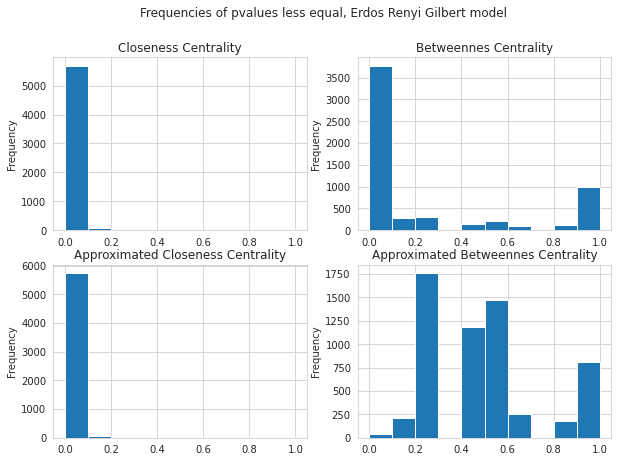

In [137]:
figure, axis = plt.subplots(2, 2, figsize=(10,7))
figure.suptitle("Frequencies of pvalues less equal, Erdos Renyi Gilbert model")
df_test_CC["pvalue-le"].plot(kind='hist', ax= axis[0,0], title="Closeness Centrality")
df_test_BC["pvalue-le"].plot(kind='hist', ax= axis[0,1], title="Betweennes Centrality")
df_test_approxCC["pvalue-le"].plot(kind='hist', ax= axis[1,0], title="Approximated Closeness Centrality")
df_test_approxBC["pvalue-le"].plot(kind='hist', ax= axis[1,1], title="Approximated Betweennes Centrality")
plt.savefig('ERle.pdf')  

In [138]:
df_test_BC_CL = generateDataFrame(nkG, "BC", 10, "CL")
df_test_CC_CL = generateDataFrame(nkG, "CC", 10, "CL")
df_test_approxCC_CL = generateDataFrame(nkG, "approxCC", 10, "CL")
df_test_approxBC_CL = generateDataFrame(nkG, "approxBC", 10, "CL")

10it [00:50,  5.03s/it]
0it [00:00, ?it/s]

--- 4.590976715087891 seconds ---


10it [00:04,  2.29it/s]


--- 0.4904599189758301 seconds ---


10it [00:00, 22.46it/s]
0it [00:00, ?it/s]

--- 0.05028533935546875 seconds ---


10it [00:09,  1.08it/s]


--- 0.9751784801483154 seconds ---


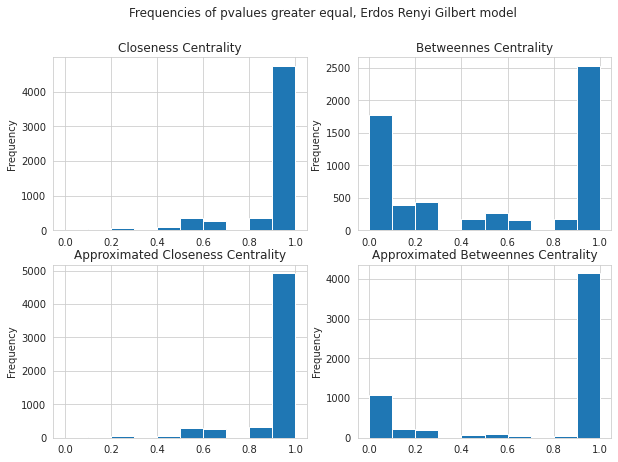

In [139]:
figure, axis = plt.subplots(2, 2, figsize=(10,7))
figure.suptitle("Frequencies of pvalues greater equal, Erdos Renyi Gilbert model")
df_test_CC_CL["pvalue-ge"].plot(kind='hist', ax= axis[0,0], title="Closeness Centrality")
df_test_BC_CL["pvalue-ge"].plot(kind='hist', ax= axis[0,1], title="Betweennes Centrality")
df_test_approxCC_CL["pvalue-ge"].plot(kind='hist', ax= axis[1,0], title="Approximated Closeness Centrality")
df_test_approxBC_CL["pvalue-ge"].plot(kind='hist', ax= axis[1,1], title="Approximated Betweennes Centrality")
plt.savefig('ERge.pdf') 

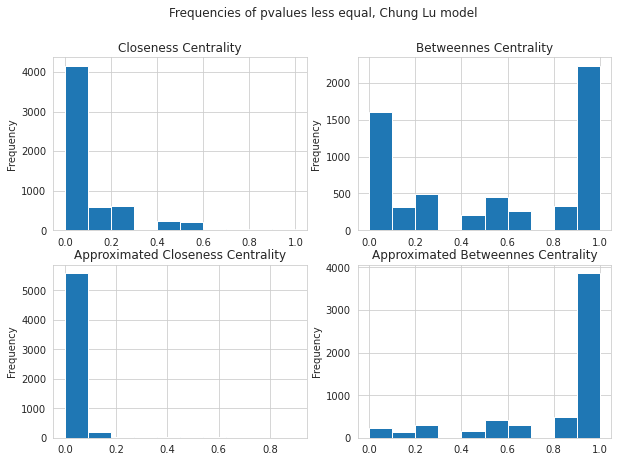

In [140]:
figure, axis = plt.subplots(2, 2, figsize=(10,7))
figure.suptitle("Frequencies of pvalues less equal, Chung Lu model")
df_test_CC_CL["pvalue-le"].plot(kind='hist', ax= axis[0,0], title="Closeness Centrality")
df_test_BC_CL["pvalue-le"].plot(kind='hist', ax= axis[0,1], title="Betweennes Centrality")
df_test_approxCC_CL["pvalue-le"].plot(kind='hist', ax= axis[1,0], title="Approximated Closeness Centrality")
df_test_approxBC_CL["pvalue-le"].plot(kind='hist', ax= axis[1,1], title="Approximated Betweennes Centrality")
plt.savefig('CLle.pdf')

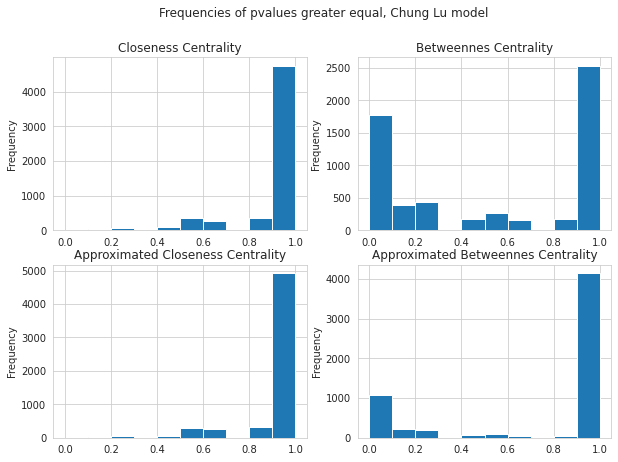

In [141]:
figure, axis = plt.subplots(2, 2, figsize=(10,7))
figure.suptitle("Frequencies of pvalues greater equal, Chung Lu model")
df_test_CC_CL["pvalue-ge"].plot(kind='hist', ax= axis[0,0], title="Closeness Centrality")
df_test_BC_CL["pvalue-ge"].plot(kind='hist', ax= axis[0,1], title="Betweennes Centrality")
df_test_approxCC_CL["pvalue-ge"].plot(kind='hist', ax= axis[1,0], title="Approximated Closeness Centrality")
df_test_approxBC_CL["pvalue-ge"].plot(kind='hist', ax= axis[1,1], title="Approximated Betweennes Centrality")
plt.savefig('CLge.pdf')

### Z-scores <a id="zscores"></a>

/home/cristianoc/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cristianoc/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


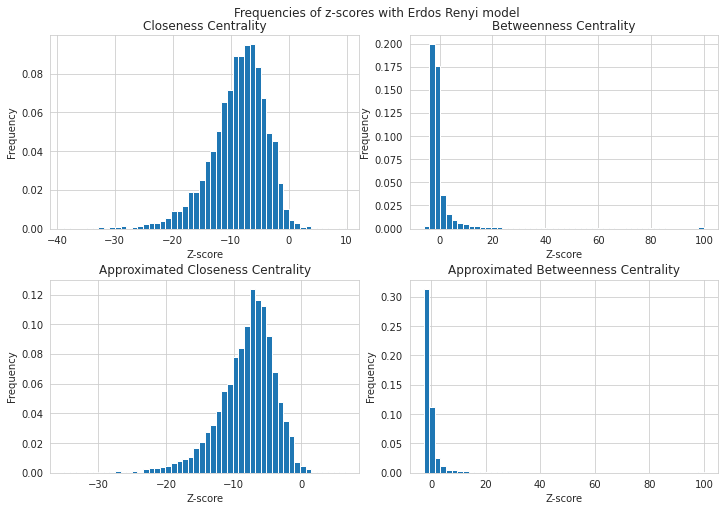

In [142]:
df_test_BC['zscore'] = df_test_BC['zscore'].clip(-100,100)
df_test_approxBC['zscore'] = df_test_approxBC['zscore'].clip(-100,100)

figure, axis = plt.subplots(2, 2, figsize=(10,7))
figure.suptitle("Frequencies of z-scores with Erdos Renyi model")
figure.tight_layout(h_pad=3, w_pad=2)
axis[0,0].hist(df_test_CC['zscore'], density=True, bins=50)
axis[0,0].set_ylabel('Frequency')
axis[0,0].set_xlabel('Z-score')
axis[0,0].set_title('Closeness Centrality')
axis[0,1].hist(df_test_BC['zscore'], density=True, bins=50)
axis[0,1].set_ylabel('Frequency')
axis[0,1].set_xlabel('Z-score')
axis[0,1].set_title('Betweenness Centrality')
axis[1,0].hist(df_test_approxCC['zscore'], density=True, bins=50)
axis[1,0].set_ylabel('Frequency')
axis[1,0].set_xlabel('Z-score')
axis[1,0].set_title('Approximated Closeness Centrality')
axis[1,1].hist(df_test_approxBC['zscore'], density=True, bins=50)
axis[1,1].set_ylabel('Frequency')
axis[1,1].set_xlabel('Z-score')
axis[1,1].set_title('Approximated Betweenness Centrality')
plt.savefig('ERzc.pdf')

In [143]:
df_test_CC.loc[keys10cc][:5]

,zscore,centrality_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,9.682357,0.358857,0.285650,0.007561,0.0,1.0
853,2.972837,0.323508,0.283160,0.013572,0.0,1.0
941,3.403209,0.320471,0.284703,0.010510,0.0,1.0
855,3.750443,0.317422,0.284287,0.008835,0.0,1.0
228,4.087112,0.312467,0.286949,0.006243,0.0,1.0


In [144]:
df_test_BC.loc[keys10bc][:5]

,zscore,centrality_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,100.0,0.536616,0.000895,0.000401,0.0,1.0
177,100.0,0.111042,0.001091,0.000442,0.0,1.0
157,100.0,0.108292,0.000765,0.000280,0.0,1.0
810,100.0,0.096549,0.000632,0.000351,0.0,1.0
255,100.0,0.090176,0.000897,0.000411,0.0,1.0


In [145]:
df_test_approxCC.loc[keys10acc][:5]

,zscore,centrality_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,6.411298,0.350877,0.285712,0.010164,0.0,1.0
853,5.202945,0.323508,0.283155,0.007756,0.0,1.0
228,0.963468,0.294985,0.286842,0.008452,0.3,0.8
855,2.765084,0.308642,0.289008,0.007101,0.0,1.0
941,3.216378,0.308642,0.282564,0.008108,0.0,1.0


In [146]:
df_test_approxBC.loc[keys10abc][:5]

,zscore,centrality_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,100.000000,0.267283,0.000278,0.000326,0.0,1.0
177,100.000000,0.053730,0.000515,0.000530,0.0,1.0
157,100.000000,0.048597,0.000357,0.000394,0.0,1.0
810,100.000000,0.054415,0.000198,0.000209,0.0,1.0
255,96.864917,0.045859,0.000595,0.000467,0.0,1.0


/home/cristianoc/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cristianoc/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


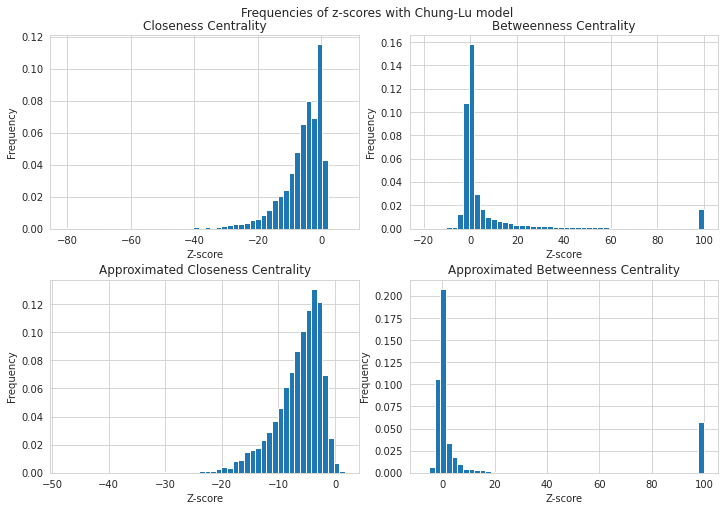

In [147]:
figure, axis = plt.subplots(2, 2, figsize=(10,7))
figure.suptitle("Frequencies of z-scores with Chung-Lu model")
figure.tight_layout(h_pad=3, w_pad=2)
axis[0,0].hist(df_test_CC_CL['zscore'], density=True, bins=50)
axis[0,0].set_ylabel('Frequency')
axis[0,0].set_xlabel('Z-score')
axis[0,0].set_title('Closeness Centrality')
axis[0,1].hist(df_test_BC_CL['zscore'].clip(-100, 100), density=True, bins=50)#clip bc of value inf
axis[0,1].set_ylabel('Frequency')
axis[0,1].set_xlabel('Z-score')
axis[0,1].set_title('Betweenness Centrality')
axis[1,0].hist(df_test_approxCC_CL['zscore'], density=True, bins=50)
axis[1,0].set_ylabel('Frequency')
axis[1,0].set_xlabel('Z-score')
axis[1,0].set_title('Approximated Closeness Centrality')
axis[1,1].hist(df_test_approxBC_CL['zscore'].clip(-100, 100), density=True, bins=50)#clip bc of value inf
axis[1,1].set_ylabel('Frequency')
axis[1,1].set_xlabel('Z-score')
axis[1,1].set_title('Approximated Betweenness Centrality')
plt.savefig('CLzc.pdf')

In [148]:
df_test_CC_CL.loc[keys10cc][:5]

,zscore,centrality_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,7.344806,0.358857,0.318886,0.005442,0.0,1.0
853,1.073097,0.323508,0.316505,0.006526,0.2,0.8
941,1.766387,0.320471,0.313289,0.004066,0.1,0.9
855,-0.096683,0.317422,0.318106,0.007078,0.5,0.5
228,-5.210803,0.312467,0.339303,0.005150,1.0,0.0


In [149]:
df_test_BC_CL.loc[keys10bc][:5]

,zscore,centrality_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,1175.417710,0.536616,0.001569,0.000455,0.0,1.0
177,94.232606,0.111042,0.004275,0.001133,0.0,1.0
157,66.399094,0.108292,0.004321,0.001566,0.0,1.0
810,294.435739,0.096549,0.000923,0.000325,0.0,1.0
255,105.419387,0.090176,0.002984,0.000827,0.0,1.0


In [150]:
df_test_approxCC_CL.loc[keys10acc][:5]

,zscore,centrality_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,1.721812,0.363636,0.342239,0.012427,0.1,0.9
853,-2.448605,0.320513,0.345137,0.010056,1.0,0.0
228,-4.556330,0.317460,0.363107,0.010018,1.0,0.0
855,-1.099016,0.317460,0.333222,0.014342,0.8,0.2
941,-1.968984,0.317460,0.342028,0.012477,0.9,0.1


In [151]:
df_test_approxBC_CL.loc[keys10abc][:5]

,zscore,centrality_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,504.845029,0.273443,0.000607,0.000540,0.0,1.0
177,55.403927,0.050308,0.002445,0.000864,0.0,1.0
157,24.557637,0.052361,0.002271,0.002040,0.0,1.0
810,70.394040,0.051677,0.000528,0.000727,0.0,1.0
255,68.935051,0.050308,0.001183,0.000713,0.0,1.0


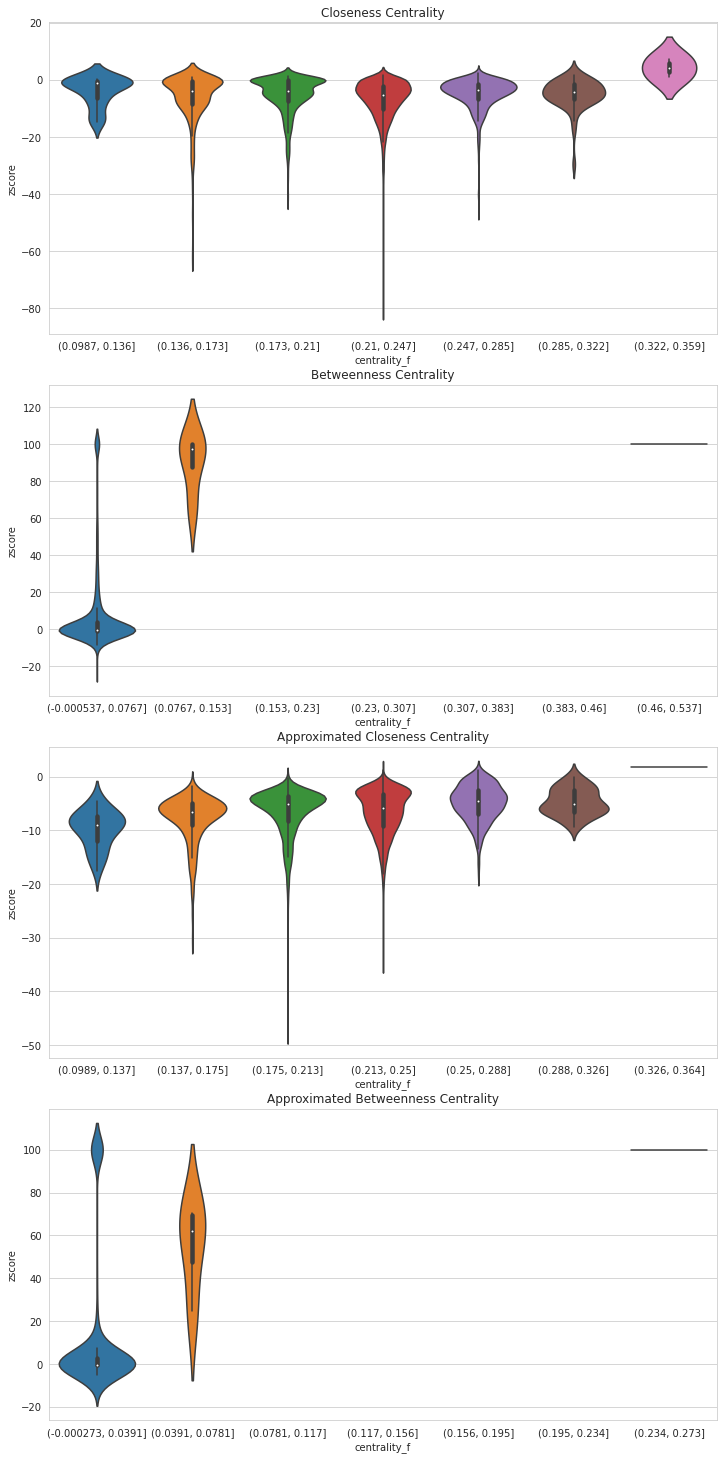

In [152]:
bins=7
df_test_BC_CL['zscore'] = df_test_BC_CL['zscore'].clip(-100,100)
df_test_approxBC_CL['zscore'] = df_test_approxBC_CL['zscore'].clip(-100,100)
fig, axes = plt.subplots(4,1,figsize=(10,20))
fig.tight_layout(h_pad=3)
sns.violinplot(x=pd.cut(df_test_CC_CL['centrality_f'], bins), y='zscore', data=df_test_CC_CL, ax=axes[0])
sns.violinplot(x=pd.cut(df_test_BC_CL['centrality_f'], bins), y='zscore', data=df_test_BC_CL, ax=axes[1])
sns.violinplot(x=pd.cut(df_test_approxCC_CL['centrality_f'], bins), y='zscore', data=df_test_approxCC_CL, ax=axes[2])
sns.violinplot(x=pd.cut(df_test_approxBC_CL['centrality_f'], bins), y='zscore', data=df_test_approxBC_CL, ax=axes[3])
axes[0].set_title("Closeness Centrality")
axes[1].set_title("Betweenness Centrality")
axes[2].set_title("Approximated Closeness Centrality")
axes[3].set_title("Approximated Betweenness Centrality")
plt.show()
fig.savefig('CLv.pdf')

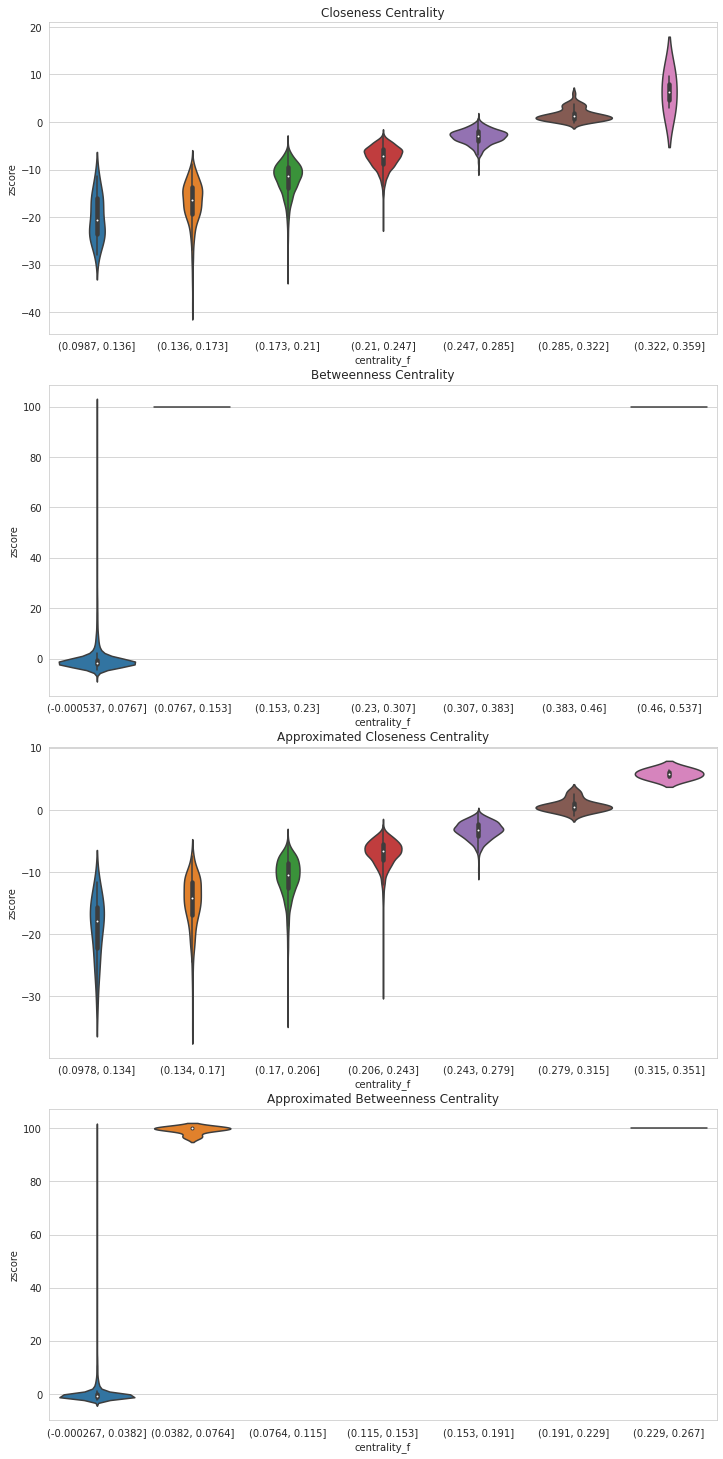

In [153]:
bins=7
fig, axes = plt.subplots(4,1,figsize=(10,20))
fig.tight_layout(h_pad=3)
sns.violinplot(x=pd.cut(df_test_CC['centrality_f'], bins), y='zscore', data=df_test_CC, ax=axes[0])
sns.violinplot(x=pd.cut(df_test_BC['centrality_f'], bins), y='zscore', data=df_test_BC, ax=axes[1])
sns.violinplot(x=pd.cut(df_test_approxCC['centrality_f'], bins), y='zscore', data=df_test_approxCC, ax=axes[2])
sns.violinplot(x=pd.cut(df_test_approxBC['centrality_f'], bins), y='zscore', data=df_test_approxBC, ax=axes[3])
axes[0].set_title("Closeness Centrality")
axes[1].set_title("Betweenness Centrality")
axes[2].set_title("Approximated Closeness Centrality")
axes[3].set_title("Approximated Betweenness Centrality")
plt.show()
fig.savefig('ERv.pdf')

In [154]:
df_test_LCC = generateDataFrame(nkG, "LCC", 10, "CL")

10it [00:00, 176.00it/s]


In [155]:
# no relation between centrality and clustering coefficient
df_test_LCC.loc[keys10bc][:5]

,zscore,clusteringCoeff_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,-1.028616,0.010471,0.022861,0.012046,0.9,0.1
177,2.177949,0.041825,0.019512,0.010245,0.1,0.9
157,4.415297,0.061489,0.022394,0.008854,0.0,1.0
810,-1.403845,0.010563,0.021348,0.007682,0.9,0.1
255,15.565400,0.139546,0.022522,0.007518,0.0,1.0


In [156]:
df_test_LCC.loc[keys10cc][:5]

,zscore,clusteringCoeff_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,-1.028616,0.010471,0.022861,0.012046,0.9,0.1
853,6.392224,0.123345,0.027001,0.015072,0.0,1.0
941,13.120464,0.177548,0.021878,0.011865,0.0,1.0
855,9.594980,0.155249,0.025712,0.013500,0.0,1.0
228,8.381710,0.071461,0.022241,0.005872,0.0,1.0


there are cases where the z-score is inf because of 0 std.

In [157]:
r = df_test_LCC.index[np.isinf(df_test_LCC).any(1)]
df_test_LCC.loc[r]

,zscore,clusteringCoeff_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
2983,inf,0.560440,0.0,0.0,0.0,1.0
3016,inf,0.547641,0.0,0.0,0.0,1.0
3040,inf,0.200000,0.0,0.0,0.0,1.0
3087,inf,0.952381,0.0,0.0,0.0,1.0
3108,inf,0.666667,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
5862,inf,1.000000,0.0,0.0,0.0,1.0
5874,inf,0.333333,0.0,0.0,0.0,1.0
5875,inf,1.000000,0.0,0.0,0.0,1.0


or NaN when f and std and mean are zero

In [158]:
s = df_test_LCC.index[np.isnan(df_test_LCC).any(1)]
df_test_LCC.loc[s]

,zscore,clusteringCoeff_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
3205,NaN,0.0,0.0,0.0,1.0,1.0
3379,NaN,0.0,0.0,0.0,1.0,1.0
3433,NaN,0.0,0.0,0.0,1.0,1.0
3459,NaN,0.0,0.0,0.0,1.0,1.0
3587,NaN,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...
5900,NaN,0.0,0.0,0.0,1.0,1.0
5901,NaN,0.0,0.0,0.0,1.0,1.0
5903,NaN,0.0,0.0,0.0,1.0,1.0


In [159]:
np.ceil(np.max(df_test_LCC[np.isfinite(df_test_LCC)])['zscore'])

494.0

In [160]:
df_test_LCC = df_test_LCC.clip(-100,np.ceil(np.max(df_test_LCC[np.isfinite(df_test_LCC)])['zscore']))

/home/cristianoc/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cristianoc/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


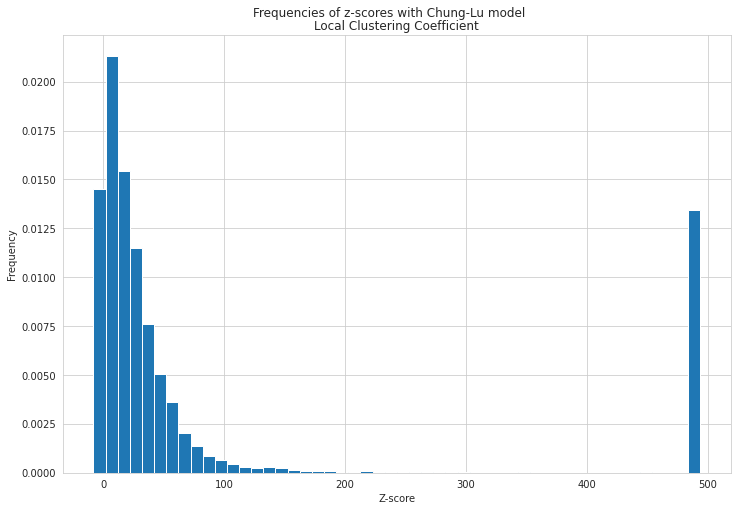

In [161]:
figure, axis = plt.subplots(1, 1, figsize=(10,7))
figure.suptitle("Frequencies of z-scores with Chung-Lu model")
figure.tight_layout(h_pad=3, w_pad=2)
axis.hist(df_test_LCC['zscore'], density=True, bins=50)
axis.set_ylabel('Frequency')
axis.set_xlabel('Z-score')
axis.set_title('Local Clustering Coefficient')
fig.savefig('LCC_cl.pdf')

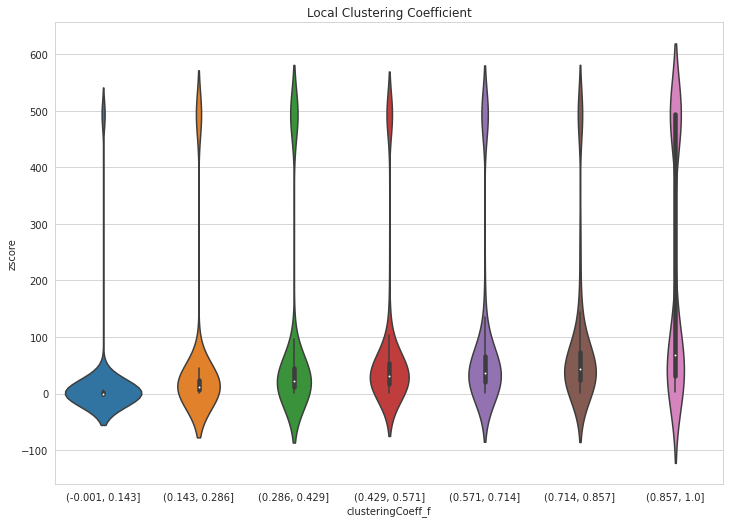

<Figure size 432x288 with 0 Axes>

In [162]:
bins=7
fig, axes = plt.subplots(1,1,figsize=(10,7))
fig.tight_layout(h_pad=3)
sns.violinplot(x=pd.cut(df_test_LCC['clusteringCoeff_f'], bins), y='zscore', data=df_test_LCC, ax=axes)
axes.set_title("Local Clustering Coefficient")
plt.show()
plt.savefig('LCC_clv.pdf')

In [163]:
RndGraphs = generateRandGraphs("ER", 10, [nkG.numberOfNodes(), 0.0025])
globalClusteringCoeffRand = list(map(nk.globals.ClusteringCoefficient.exactGlobal,RndGraphs))
globalClusteringCoeff = nk.globals.ClusteringCoefficient.exactGlobal(nkG)
zscore_globalClusteringCoeff = zscore(globalClusteringCoeff, np.mean(globalClusteringCoeffRand), np.std(globalClusteringCoeffRand))

In [164]:
print("With Erdos Renyi model")
print("Global clustering coefficient: \n{}".format(globalClusteringCoeffRand))
print("z-score global clustering coefficient: {}".format(zscore_globalClusteringCoeff))

With Erdos Renyi model
Global clustering coefficient: 
[0.002653580795766577, 0.002420073679851347, 0.002391897447396943, 0.002557190147491417, 0.0024314232055908623, 0.002279194279081957, 0.0027729157070474435, 0.002493796641936257, 0.0024769237905283175, 0.0025201723291022804]
z-score global clustering coefficient: 2264.5650189920257


In [165]:
plarger_, psmaller_ = pvalues(globalClusteringCoeffRand, globalClusteringCoeff)
plarger_, psmaller_

(0.0, 1.0)

In [166]:
degreeSequence = [nkG.degree(v) for v in nkG.iterNodes()]
RndGraphs = generateRandGraphs("CL", 10, degreeSequence)
globalClusteringCoeffRand = list(map(nk.globals.ClusteringCoefficient.exactGlobal,RndGraphs))
globalClusteringCoeff = nk.globals.ClusteringCoefficient.exactGlobal(nkG)
zscore_globalClusteringCoeff = zscore(globalClusteringCoeff, np.mean(globalClusteringCoeffRand), np.std(globalClusteringCoeffRand))

In [167]:
print("With Chung-Lu model")
print("Global clustering coefficient: \n{}".format(globalClusteringCoeffRand))
print("z-score global clustering coefficient: {}".format(zscore_globalClusteringCoeff))

With Chung-Lu model
Global clustering coefficient: 
[0.022220400954047172, 0.021547844452769166, 0.021476323026992938, 0.021721867076580997, 0.021670646787739934, 0.021534835964385022, 0.021038408039288047, 0.021690729728536046, 0.02214733303628334, 0.021355130115942308]
z-score global clustering coefficient: 844.9224331765546


In [168]:
plarger_, psmaller_ = pvalues(globalClusteringCoeffRand, globalClusteringCoeff)
plarger_, psmaller_

(0.0, 1.0)